# C-N Benchmark Visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cn_benchmark_visualization import DomainWrapper, PlotExperiments
from summit.benchmarks import BaumgartnerCrossCouplingEmulator_Yield_Cost
from summit.strategies import Random
from summit.utils.multiobjective import hypervolume, pareto_efficient

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Pareto Front

In [ ]:
exp = BaumgartnerCrossCouplingEmulator_Yield_Cost()
exp.domain

In [33]:
def random_test(n_points, random_seed, hypervolume_ref=[0,1]):
    rand = Random(exp.domain, 
                  random_state=np.random.RandomState(random_seed))
    experiments = rand.suggest_experiments(n_points)
    exp.reset()
    exp.run_experiments(experiments)
    
    # Pareto front
    clear_output(wait=True)
    fig, ax = exp.pareto_plot()
    pareto_data = exp.pareto_data[['yld', 'cost']].to_numpy()
    pareto_data[:,0] *= -1.0 # change yld to minimization
    
    # Hypervolume
    hv = hypervolume(pareto_data, hypervolume_ref)
    
    #Formatting
    fig.suptitle(f'{n_points} points, hypervolume={hv}')
    plt.show()
    
    return hv

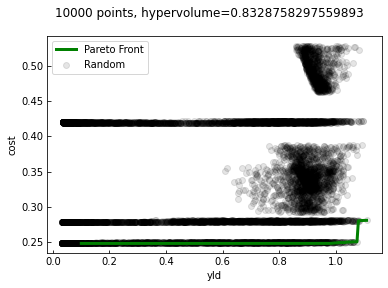

In [34]:
points = [100, 1000, 5000, int(1e4)]
hvs = []
for n_points in points:
    hvs.append(random_test(n_points, 100))

## CN Experiments

In [6]:
ids = [f'SUM-{i}' for i in range(1988, 2552)] + [f'SUM-{i}' for i in range(3712, 3814)]
results = PlotExperiments("sustainable-processes/summit",
                          trajectory_length=50,
                          experiment_ids=ids,
                          tag=['cn_experiment', 'cn_experiment_MO'],
                          state=['succeeded'])

In [7]:
print("Number of experiments for this benchmark:", len(results.runners)*50)

Number of experiments for this benchmark: 17950


Let's make an interactive plot of the hypervolume trajectories, for exploration sake. 

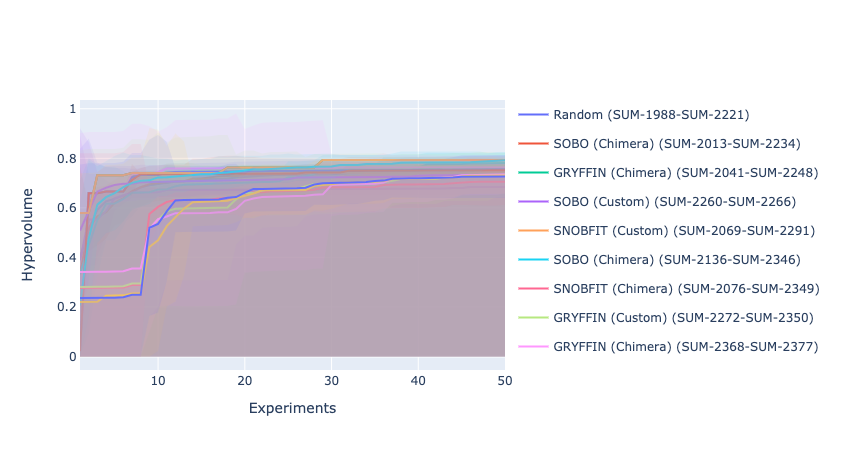

In [8]:
fig = results.plot_hv_trajectories(min_terminal_hv_avg=0.5, 
                                   include_experiment_ids=True,plot_type='plotly')

You can double click on an item in the legend to solo it. I'm going to increase the threshold for the publication figure, so I only include the top three strategies.

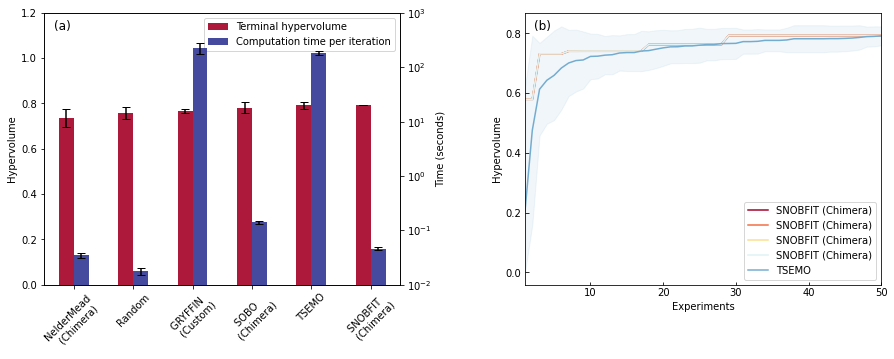

In [9]:
# Create figure
fig  = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.35,)

# Hypervolume, Time bar plot
ax = fig.add_subplot(1, 2, 1)
results.time_hv_bar_plot(ax)
ax.text(0.05,0.95, '(a)',
         horizontalalignment='center', 
         verticalalignment='center',
         transform = ax.transAxes,
         fontdict={'fontsize': 12})
ax.set_ylim(0,1.2)
ax.right_ax.set_ylim(1e-2, 1e3)

# Hypervolume trajectory plot
ax = fig.add_subplot(1, 2, 2)
ax, legend = results.plot_hv_trajectories(min_terminal_hv_avg=0.79, 
                                          include_experiment_ids=False,plot_type='matplotlib',
                                          ax=ax)
ax.legend(loc="lower right")
ax.text(0.05,0.95, '(b)',
         horizontalalignment='center', 
         verticalalignment='center',
         transform = ax.transAxes,
         fontdict={'fontsize': 12})

# Save figure
fig.savefig("figures/cn_hv_time_tradeoff.png", dpi=300, bbox_inches='tight')

# TODO: print out caption with transform settings.

In [18]:
df = results.df.copy()
df["computation_t"] = df["computation_t"]/results.trajectory_length
# Group repeats and take average
grouped_df = df.groupby(
    by=[
        "strategy_name",
        "transform_name",
        "yld_tolerance",
        "cost_tolerance",
        "batch_size",
        "num_initial_experiments",
    ],
    dropna=False,
)
stds = grouped_df.std().round(2)
counts = grouped_df.count()['experiment_id']
grouped_df = grouped_df.mean().round(2)
for col in ["terminal_hypervolume", 'computation_t']:
    grouped_df[col] = [f"{m}$\pm${s}"
                       for m, s in zip(grouped_df[col].values,
                                       stds[col].values)
                     ]
grouped_df['Repeats'] = counts
grouped_df

grouped_df.rename(columns={"terminal_hypervolume": "Terminal hypervolume",
                           "computation_t": "Time per iter. (s)"},
                  inplace=True)
grouped_df.index.rename(["Strategy", "Transform","STY tolerance",
                         "E-factor tolerance", "batch_size", "num_initial_experiments"],
                        inplace=True)
grouped_df.index = grouped_df.index.droplevel(["batch_size", "num_initial_experiments"])
grouped_df = grouped_df.fillna('-').round(0)
grouped_df

Terminal hypervolume  \
Strategy   Transform              STY tolerance E-factor tolerance                        
GRYFFIN    Chimera                0.5           0.5                       0.76$\pm$0.01   
                                                1.0                       0.75$\pm$0.02   
                                  1.0           0.5                       0.76$\pm$0.02   
                                                1.0                        0.76$\pm$0.0   
           MultitoSingleObjective NaN           NaN                       0.77$\pm$0.01   
NelderMead Chimera                0.5           0.5                       0.73$\pm$0.04   
                                                1.0                       0.73$\pm$0.05   
                                  1.0           0.5                       0.71$\pm$0.05   
                                                1.0                       0.73$\pm$0.04   
           MultitoSingleObjective NaN           NaN                       0.73$\pm$0.05   
Random     Transform              NaN           NaN                       0.76$\pm$0.03   
SNOBFIT    Chimera                0.5           0.5                        0.79$\pm$0.0   
                                                1.0                        0.79$\pm$0.0   
                                  1.0           0.5                        0.79$\pm$0.0   
                                                1.0                        0.79$\pm$0.0   
           MultitoSingleObjective NaN           NaN                        0.75$\pm$0.0   
SOBO       Chimera                0.5           0.5                       0.73$\pm$0.03   
                                  1.0           0.5                       0.75$\pm$0.03   
                                                1.0                       0.78$\pm$0.02   
           MultitoSingleObjective NaN           NaN                       0.68$\pm$0.02   
TSEMO      Transform              NaN           NaN                       0.79$\pm$0.02   

                                                                   Time per iter. (s)  \
Strategy   Transform              STY tolerance E-factor tolerance                      
GRYFFIN    Chimera                0.5           0.5                  193.81$\pm$28.83   
                                                1.0                  178.79$\pm$20.69   
                                  1.0           0.5                   264.77$\pm$67.1   
                                                1.0                  171.63$\pm$15.17   
           MultitoSingleObjective NaN           NaN                  229.37$\pm$53.16   
NelderMead Chimera                0.5           0.5                      0.04$\pm$0.0   
                                                1.0                      0.03$\pm$0.0   
                                  1.0           0.5                     0.04$\pm$0.01   
                                                1.0                      0.03$\pm$0.0   
           MultitoSingleObjective NaN           NaN                      0.04$\pm$0.0   
Random     Transform              NaN           NaN                      0.02$\pm$0.0   
SNOBFIT    Chimera                0.5           0.5                      0.05$\pm$0.0   
                                                1.0                      0.04$\pm$0.0   
                                  1.0           0.5                      0.05$\pm$0.0   
                                                1.0                      0.05$\pm$0.0   
           MultitoSingleObjective NaN           NaN                     0.07$\pm$0.01   
SOBO       Chimera                0.5           0.5                      0.14$\pm$0.0   
                                  1.0           0.5                     0.15$\pm$0.01   
                                                1.0                     0.14$\pm$0.01   
           MultitoSingleObjective NaN           NaN                     0.24$\pm$0.01   
TSEMO      Tran

In [569]:
latex_str = grouped_df.to_latex(index=True, escape=False, bold_rows=False)
latex_str = latex_str.replace("MultitoSingleObjective", "Custom")
latex_str = latex_str.replace('NaN', '-')
print(latex_str)

\begin{tabular}{llllll}
\toprule
      &           &     &     & Terminal hypervolume & Time per iter. (s) \\
Strategy & Transform & STY tolerance & E-factor tolerance &                      &                    \\
\midrule
DRO & Chimera & 0.5 & 0.5 &          0.0$\pm$0.0 &       0.4$\pm$0.02 \\
      &           &     & 1.0 &          0.0$\pm$0.0 &      0.41$\pm$0.01 \\
      &           & 1.0 & 0.5 &          0.0$\pm$0.0 &      0.35$\pm$0.04 \\
      &           &     & 1.0 &       2.75$\pm$11.15 &      0.37$\pm$0.05 \\
      & Custom & - & - &    148.17$\pm$409.75 &      0.38$\pm$0.02 \\
GRYFFIN & Chimera & 0.5 & 0.5 &    857.3$\pm$1302.72 &    77.64$\pm$11.19 \\
      &           &     & 1.0 &   1410.21$\pm$2297.5 &    77.57$\pm$10.92 \\
      &           & 1.0 & 0.5 &  1714.99$\pm$1766.34 &     106.3$\pm$19.3 \\
      &           &     & 1.0 &  1929.63$\pm$1582.05 &    87.04$\pm$11.93 \\
      & Custom & - & - &   555.47$\pm$1069.18 &    89.71$\pm$10.44 \\
NelderMead & Chimera & 0

I made the above parallel plot to show how the decision variables correspond with the objectives. However, I don't think it's clean enough for a publication.

Below, are the pareto plots for the run from each combination of strategy and transform that had the highest terminal hypervolume.

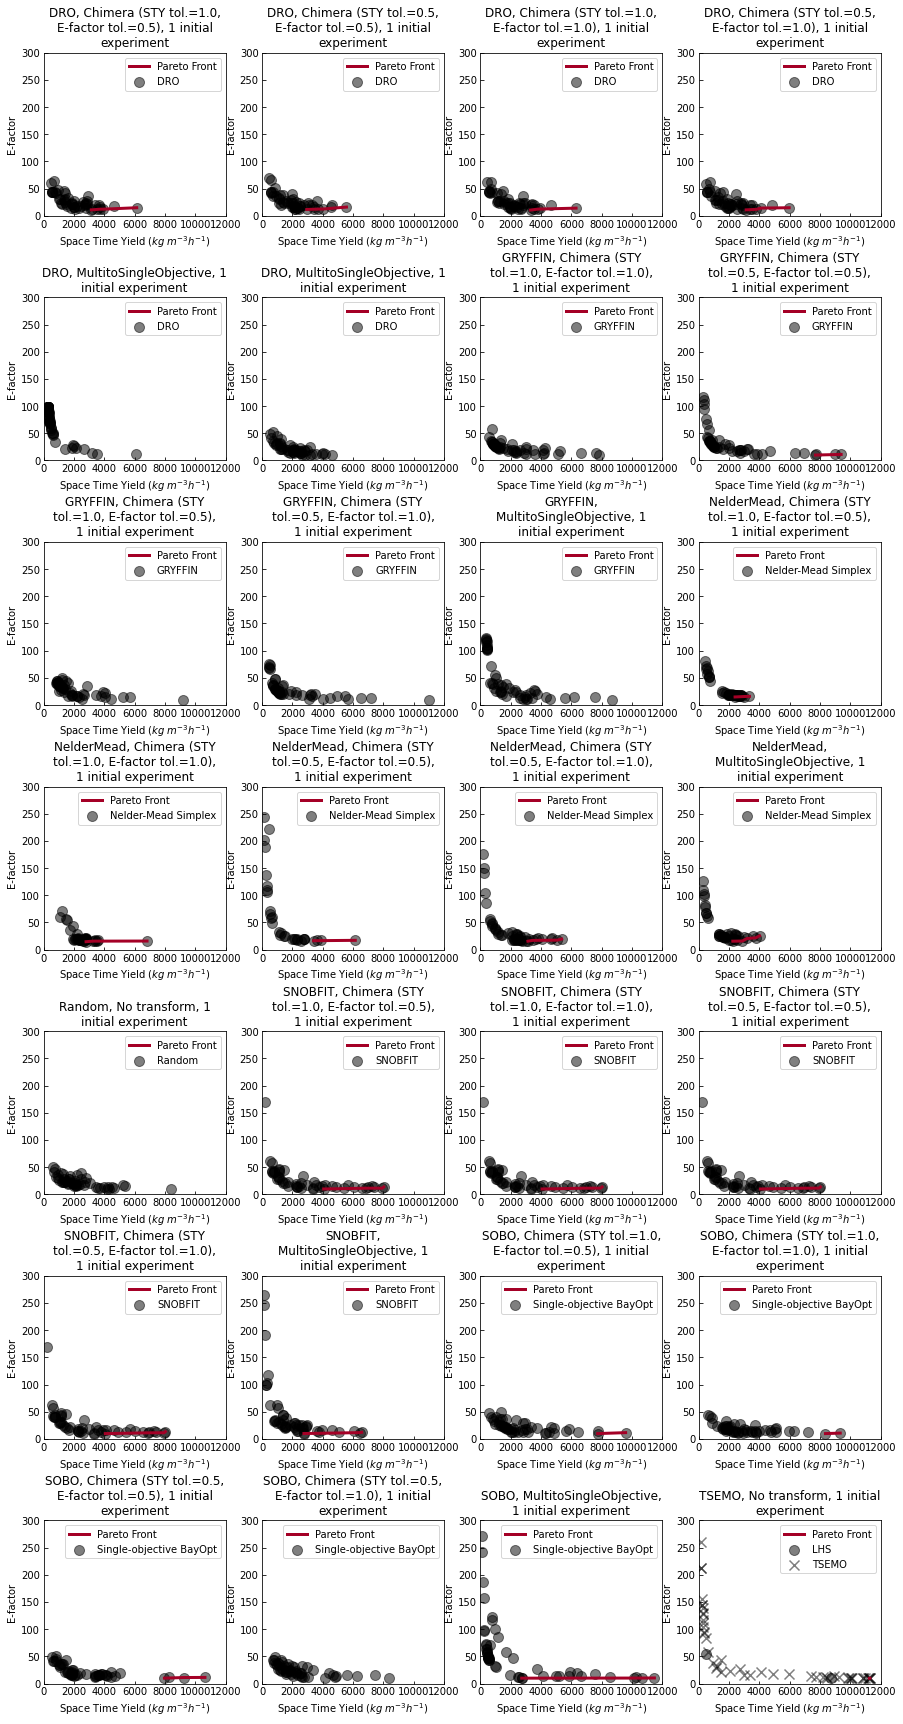

In [488]:
fig = results.best_pareto_grid(ncols=4, figsize=(15, 30))
fig.savefig('figures/snar_pareto_fronts.png', dpi=300, bbox_inches='tight')